# MNIST Sequence Classification 

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

## Set Parameter

In [6]:
# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1 - test_size) * num_datapoints)

# Network params
input_size = 2
hidden_layer = 128
output_dim = 10
num_layers = 2
num_epochs = 500
dtype = torch.float
input_seq = 100
pred_length = 1
batch_size = 32
train_samples = 10
test_samples = 100

## Load data

In [7]:
def load_data(train=True, seq_pred=True):
    extract_file = './sequences/extracted_data_label.npz'
    if not os.path.isfile(extract_file):
        data = []
        label = []
        max_seq_len = 0
        for file in tqdm(os.listdir('./sequences/')):
            if file.endswith('inputdata.txt'):
                curr_seq = np.loadtxt(os.path.join('./sequences/', file), delimiter=' ')
                data.append(np.cumsum(curr_seq[:, 0:2], axis=0))
                if curr_seq.shape[0] > max_seq_len:
                    max_seq_len = curr_seq.shape[0]
                target_file = file.replace('inputdata', 'targetdata')
                tar_seq = np.loadtxt(os.path.join('./sequences/', target_file), delimiter=' ')
                tmp_label = tar_seq[0, 0:10]
                tmp_label = np.where(tmp_label==1)[0]
                label.append(tmp_label)
        for i in range(len(data)):
            if data[i].shape[0] < max_seq_len:
                data[i] = np.concatenate(
                    [data[i], np.array([data[i][-1, :].tolist(), ] * (max_seq_len - data[i].shape[0]))], axis=0)
        data = np.array(data)
        label = np.array(label)
        np.savez(extract_file, data, label)
    else:
        data_label = np.load(extract_file)
        data = data_label[data_label.files[0]]
        label = data_label[data_label.files[1]]
    if seq_pred:
        if train:
            x = data[0:60000, 0:input_seq, :]
            y = data[0:60000, input_seq:input_seq+pred_length, :]
            x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
            y = y[0:int(x.shape[0] / batch_size) * batch_size, :]

            return (x, y)
        else:
            x = data[60000:, 0:input_seq, :]
            y = data[60000:, input_seq:input_seq+pred_length, :]
            x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
            y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
            return (x, y)
    else:
        if train:
            x = data[0:60000, 0:input_seq, :]
            y = label[0:60000, :]
            x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
            y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
            return (x, y)
        else:
            x = data[60000:, 0:input_seq, :]
            y = label[60000:, :]
            x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
            y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
            return (x, y)

(x_data, y_data) = load_data(True, seq_pred=False)
(x_data_test, y_data_test) = load_data(False, seq_pred=False)

output_seq = y_data.shape[1]
print(x_data.shape)
print(y_data.shape)

(60000, 100, 2)
(60000, 1)


In [8]:
class BatchGenerator(object):
    def __init__(self, data_x, data_y, batch_size=batch_size, output_seq=output_seq, n_action=2):
        self.data_x = data_x  # np.reshape(data_x, (data_x.shape[0], -1))
        self.data_y = data_y  # np.reshape(data_y, (data_y.shape[0], -1))
        self.batch_size = batch_size
        self.output_seq = output_seq
        self.n_action = n_action

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        indices = np.random.randint(0, len(self.data_x), batch_size)
        x_batch = torch.tensor(self.data_x[indices, :, :]).to(torch.float)
        y_batch = torch.tensor(self.data_y[indices, :]).squeeze(1).to(torch.long)
        return x_batch, y_batch

## Build Model

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.batch_size, self.hidden_size)

rnn = RNN(input_size, hidden_layer, batch_size, output_dim)
train_data_generator = BatchGenerator(x_data, y_data, batch_size=batch_size)
test_data_generator = BatchGenerator(x_data_test, y_data_test, batch_size=batch_size)

### Test Model

In [10]:
x_batch, y_batch = train_data_generator.sample()
print(x_batch.shape)

# hidden Layer initialization
hidden = torch.zeros(1, hidden_layer).to(torch.float)

in_sample = x_batch[0, 0, :].unsqueeze(0)
output, next_hidden = rnn(in_sample, hidden)
print(output)

in_sample = x_batch[0, 1, :].unsqueeze(0)
output, next_hidden = rnn(in_sample, next_hidden)
print(output)

torch.Size([32, 100, 2])
tensor([[-2.1101, -3.5716, -2.4679, -2.9197, -2.7238, -1.7236, -1.6601, -2.7064,
         -2.2194, -2.2794]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.2607, -3.3950, -1.7113, -3.1146, -3.1604, -2.0007, -1.5990, -3.0767,
         -2.3047, -2.1937]], grad_fn=<LogSoftmaxBackward>)


## Train Function  

In [18]:
loss_fn = torch.nn.NLLLoss()
learning_rate = 5e-4
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(x_tensor, y_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(x_tensor.size()[1]):
        input_tensor = x_tensor[:, i, :]
        output, hidden = rnn(input_tensor, hidden)

    loss = loss_fn(output, y_tensor)

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    return output, loss.item()


def predict(x_tensor, y_tensor, test_size):
    with torch.no_grad():
        hidden = torch.zeros(test_size, hidden_layer).to(torch.float)

        for i in range(x_tensor.size()[1]):
            input_tensor = x_tensor[:, i, :]
            output, hidden = rnn(input_tensor, hidden)

        loss = loss_fn(output, y_tensor)
    predictions = np.argmax(output.cpu().numpy(), axis=1)
    correct_predictions = (predictions == y_tensor.cpu().numpy()).astype(int)
    acc = np.mean(correct_predictions)
    return loss.item(), acc

## Train Model

In [19]:
import time
import math

n_iters = 2000
plot_every = 100
test_size = 2048

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    x_batch, y_batch = train_data_generator.sample()
    # category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(x_batch, y_batch)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        print("current_loss: ", current_loss/plot_every)
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        # test_loss
        x_test_batch, y_test_batch = test_data_generator.sample(batch_size=test_size)
        test_loss, accuracy = predict(x_test_batch, y_test_batch, test_size)
        print("current_test_loss: ", test_loss)
        print("current_test_accuracy: ", accuracy)
        all_test_losses.append(test_loss)

current_loss:  15.792415270805359
current_test_loss:  13.665740966796875
current_loss:  18.779284076690672
current_test_loss:  9.290006637573242
current_loss:  8.580991374254227
current_test_loss:  7.327641487121582
current_loss:  6.668013379573822
current_test_loss:  5.5199151039123535
current_loss:  4.442737505435944
current_test_loss:  4.1525373458862305
current_loss:  3.888294370174408
current_test_loss:  4.270051956176758
current_loss:  3.3565750336647033
current_test_loss:  3.6321611404418945
current_loss:  2.8991731715202333
current_test_loss:  2.7232325077056885
current_loss:  2.363468704223633
current_test_loss:  2.043994188308716
current_loss:  1.901738691329956
current_test_loss:  1.8412654399871826
current_loss:  1.7952604627609252
current_test_loss:  1.8340685367584229
current_loss:  1.7968754827976228
current_test_loss:  1.8726400136947632
current_loss:  1.7027635502815246
current_test_loss:  1.6815760135650635
current_loss:  1.7334135043621064
current_test_loss:  1.66760

## Plot Results 

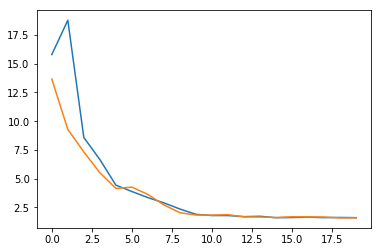

In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(all_test_losses)